## Replicate model in Preisler et al. (2017)

Their approach was to use a general additive model with a logit link function. GAMs are hard to implement in Python and do not play well with tensorflow. We will approximate this with a dense neural network with a logit activation function in the output node.

In [1]:
%%capture
pip install shap tensorboard xbatcher imbalanced-learn

In [2]:
import os

if "notebooks" in os.getcwd():
    os.chdir("..")
    print("Changed working directory to", os.getcwd())

import util

Changed working directory to /home/jovyan/ForestLST


In [6]:
import util

import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import rioxarray
import cartopy.crs as ccrs

import shutil
import json
import random

### Get data

In [8]:
ds = xr.open_dataset("data_working/westmort.nc")
bounds = ds.rio.write_crs(3857).rio.bounds()

In [9]:
ds["mort_ewma"] = xr.apply_ufunc(
    util.manip.numpy_ewma_vectorized,
    ds.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    kwargs=dict(window=3)
)

ds["mort_shift"] = ds["mort_ewma"].shift(time=1)

In [12]:
ba_vars = ["abies", "picea", "populus", "tsuga", "pseudotsuga"]
ds["forest_ba"] = ds[ba_vars].to_stacked_array("band", sample_dims=["x", "y", "time"]).sum(dim="band")

## Model definition

In [13]:
def make_simpledense(input_size, init_bias: float=None, dropout: float=0.2):
    m = torch.nn.Sequential(
        torch.nn.BatchNorm1d(input_size),
        torch.nn.Linear(input_size, 64),
        torch.nn.Dropout(p=dropout),
        torch.nn.Tanh(),
        torch.nn.Linear(64, 32),
        torch.nn.Dropout(p=dropout),
        torch.nn.Tanh(),
        torch.nn.Linear(32, 8),
        torch.nn.Dropout(p=dropout),
        torch.nn.Tanh(),
        torch.nn.Linear(8, 1),
        torch.nn.Sigmoid()
    )

    if init_bias is not None:
        torch.nn.init.constant_(m[-2].bias, init_bias)

    return m

In [14]:
sd = make_simpledense(13, init_bias=1.0)
print(sd)

Sequential(
  (0): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=13, out_features=64, bias=True)
  (2): Dropout(p=0.2, inplace=False)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): Dropout(p=0.2, inplace=False)
  (6): Tanh()
  (7): Linear(in_features=32, out_features=8, bias=True)
  (8): Dropout(p=0.2, inplace=False)
  (9): Tanh()
  (10): Linear(in_features=8, out_features=1, bias=True)
  (11): Sigmoid()
)


### Convert inputs to tensors

In [15]:
list(ds.variables.keys())

['time',
 'x',
 'y',
 'abies',
 'picea',
 'populus',
 'pseudotsuga',
 'tsuga',
 'vod',
 'elev',
 'slope',
 'northness',
 'eastness',
 'fire',
 'mortality',
 'prcp',
 'vp',
 'tmin',
 'treecover',
 'spatial_ref',
 'mort_ewma',
 'mort_shift',
 'forest_ba']

In [23]:
TARGET = ["mort_shift"]
BANDS = ["forest_ba", "prcp", "vp", "tmin", "fire", "elev", "vod", "mort_ewma"]

df = ds[TARGET + BANDS].to_dataframe().dropna().reset_index()

In [24]:
print(df.shape)
df.head()

(871416, 12)


,y,x,time,mort_shift,forest_ba,prcp,vp,tmin,fire,elev,vod,mort_ewma
0,6274302.419,-1.360222e+07,2002,0.0,8.0,1410.0,1313.0,0.0,0.0,35.0,430.0,0.0
1,6274302.419,-1.360222e+07,2003,0.0,8.0,1102.0,1262.0,0.0,0.0,35.0,430.0,0.0
2,6274302.419,-1.360222e+07,2004,0.0,8.0,1505.0,1365.0,0.0,0.0,35.0,413.0,0.0
3,6274302.419,-1.360222e+07,2005,0.0,8.0,1545.0,1363.0,0.0,0.0,35.0,425.0,0.0
4,6274302.419,-1.360222e+07,2006,0.0,8.0,1255.0,1272.0,1.0,0.0,35.0,429.0,0.0


In [27]:
years = ds.time.values

train_years = years[16:]
valid_years = years[:8]
test_years = years[8:16]

train_df = df[df.time.isin(train_years)]
valid_df = df[df.time.isin(valid_years)]
test_df  = df[df.time.isin(test_years)]

print("N rows")
print(train_df.shape[0])
print(valid_df.shape[0])
print(test_df.shape[0])

N rows
311601
160389
399426


In [38]:
from torch.utils.data import TensorDataset, DataLoader

def df_to_dataloader(df):
    # Add two dimensions
    input = torch.from_numpy(df[BANDS].to_numpy().astype(np.float32))
    output = torch.from_numpy(df[TARGET].to_numpy().astype(np.float32))/100

    ds = TensorDataset(input, output)
    
    return DataLoader(ds, batch_size=512, shuffle=True)

train_dl = df_to_dataloader(train_df)
valid_dl = df_to_dataloader(valid_df)
test_dl  = df_to_dataloader(test_df)

### Training loop

In [39]:
from importlib import reload
reload(util.training)
from util.training import BaseTrainer, ReduceLRMixin, EarlyStopMixin

# Masked loss is very slow for some reason
class Trainer(ReduceLRMixin, EarlyStopMixin, BaseTrainer):
    pass

In [40]:
import torchmetrics

# Only doing temporal split since that makes the most
# sense here.
model_name = "031425_simpledense"

y_mean = train_df.mort_ewma.mean()/100
init_bias = np.log(y_mean / (1-y_mean))
n_feats = next(iter(train_dl))[0].shape[1]

model = make_simpledense(n_feats, dropout=0.5, init_bias=init_bias)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.2, patience=3)
loss = torch.nn.MSELoss()
metrics = util.training.get_regr_metrics()

trainer = Trainer(
    model,
    opt,
    scheduler,
    loss,
    train_dl,
    valid_dl,
    metrics=metrics,
    n_epochs=30,
    tensorboard_log=os.path.join("logs", model_name, "history"),
    model_log=os.path.join("logs", model_name, "model.pth"),
    defn_log=os.path.join("logs", model_name, "model_definition.txt")
)

trainer.train()

/home/jovyan/ForestLST/util/training.py:163: UserWarning: Log already exists at logs/031425_simpledense/history
  warnings.warn(f"Log already exists at {tensorboard_log}")


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 1 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.002514
2                              Loss/valid  tensor(0.0067)
3               MeanAbsoluteError()/train      0.02294211
4               MeanAbsoluteError()/valid      0.02322939
5  NormalizedRootMeanSquaredError()/train       2.1047664
6  NormalizedRootMeanSquaredError()/valid        4.887564
7                         R2Score()/train      0.45210093
8                         R2Score()/valid      -1.0734203



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 2 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.002344
2                              Loss/valid  tensor(0.0055)
3               MeanAbsoluteError()/train     0.023721464
4               MeanAbsoluteError()/valid      0.02258076
5  NormalizedRootMeanSquaredError()/train       2.0321002
6  NormalizedRootMeanSquaredError()/valid       4.4060993
7                         R2Score()/train       0.4892801
8                         R2Score()/valid      -0.6850461



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 3 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.002321
2                              Loss/valid  tensor(0.0069)
3               MeanAbsoluteError()/train      0.02360674
4               MeanAbsoluteError()/valid     0.025040183
5  NormalizedRootMeanSquaredError()/train       2.0226002
6  NormalizedRootMeanSquaredError()/valid       4.9468093
7                         R2Score()/train      0.49404246
8                         R2Score()/valid      -1.1239917



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 4 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.002323
2                              Loss/valid  tensor(0.0066)
3               MeanAbsoluteError()/train       0.0236104
4               MeanAbsoluteError()/valid     0.023155041
5  NormalizedRootMeanSquaredError()/train       2.0230904
6  NormalizedRootMeanSquaredError()/valid         4.83197
7                         R2Score()/train       0.4937995
8                         R2Score()/valid      -1.0265217



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 5 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.002317
2                              Loss/valid  tensor(0.0040)
3               MeanAbsoluteError()/train     0.023628728
4               MeanAbsoluteError()/valid     0.019621052
5  NormalizedRootMeanSquaredError()/train       2.0212896
6  NormalizedRootMeanSquaredError()/valid        3.789702
7                         R2Score()/train      0.49469984
8                         R2Score()/valid     -0.24655855



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 6 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.002321
2                              Loss/valid  tensor(0.0054)
3               MeanAbsoluteError()/train     0.023745388
4               MeanAbsoluteError()/valid     0.022048427
5  NormalizedRootMeanSquaredError()/train       2.0227473
6  NormalizedRootMeanSquaredError()/valid          4.3806
7                         R2Score()/train      0.49397057
8                         R2Score()/valid       -0.665594



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 7 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.002344
2                              Loss/valid  tensor(0.0052)
3               MeanAbsoluteError()/train     0.023793798
4               MeanAbsoluteError()/valid     0.022119079
5  NormalizedRootMeanSquaredError()/train        2.032666
6  NormalizedRootMeanSquaredError()/valid       4.2834387
7                         R2Score()/train      0.48899537
8                         R2Score()/valid      -0.5925306



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 8 of 30
                                      Key           Value
0                            LearningRate           0.005
1                              Loss/train        0.002307
2                              Loss/valid  tensor(0.0043)
3               MeanAbsoluteError()/train     0.023602488
4               MeanAbsoluteError()/valid      0.02031784
5  NormalizedRootMeanSquaredError()/train       2.0167923
6  NormalizedRootMeanSquaredError()/valid       3.9104717
7                         R2Score()/train      0.49694502
8                         R2Score()/valid     -0.32727456



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 9 of 30
                                      Key           Value
0                            LearningRate           0.001
1                              Loss/train        0.002295
2                              Loss/valid  tensor(0.0051)
3               MeanAbsoluteError()/train     0.023517465
4               MeanAbsoluteError()/valid     0.021355009
5  NormalizedRootMeanSquaredError()/train       2.0113523
6  NormalizedRootMeanSquaredError()/valid       4.2746773
7                         R2Score()/train       0.4996552
8                         R2Score()/valid      -0.5860214



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 10 of 30
                                      Key           Value
0                            LearningRate           0.001
1                              Loss/train        0.002267
2                              Loss/valid  tensor(0.0057)
3               MeanAbsoluteError()/train     0.023510197
4               MeanAbsoluteError()/valid     0.022955569
5  NormalizedRootMeanSquaredError()/train       1.9987633
6  NormalizedRootMeanSquaredError()/valid       4.4844937
7                         R2Score()/train      0.50589836
8                         R2Score()/valid       -0.745538



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 11 of 30
                                      Key           Value
0                            LearningRate           0.001
1                              Loss/train        0.002224
2                              Loss/valid  tensor(0.0057)
3               MeanAbsoluteError()/train     0.023318361
4               MeanAbsoluteError()/valid     0.022834267
5  NormalizedRootMeanSquaredError()/train       1.9799443
6  NormalizedRootMeanSquaredError()/valid       4.4992914
7                         R2Score()/train      0.51515925
8                         R2Score()/valid     -0.75707924



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 12 of 30
                                      Key           Value
0                            LearningRate           0.001
1                              Loss/train        0.002222
2                              Loss/valid  tensor(0.0059)
3               MeanAbsoluteError()/train      0.02309929
4               MeanAbsoluteError()/valid     0.022698455
5  NormalizedRootMeanSquaredError()/train       1.9791658
6  NormalizedRootMeanSquaredError()/valid       4.5937834
7                         R2Score()/train      0.51554036
8                         R2Score()/valid      -0.8316529



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 13 of 30
                                      Key           Value
0                            LearningRate          0.0002
1                              Loss/train        0.002233
2                              Loss/valid  tensor(0.0061)
3               MeanAbsoluteError()/train     0.023219256
4               MeanAbsoluteError()/valid     0.023027562
5  NormalizedRootMeanSquaredError()/train       1.9840026
6  NormalizedRootMeanSquaredError()/valid       4.6351132
7                         R2Score()/train       0.5131693
8                         R2Score()/valid      -0.8647635



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 14 of 30
                                      Key           Value
0                            LearningRate          0.0002
1                              Loss/train        0.002218
2                              Loss/valid  tensor(0.0064)
3               MeanAbsoluteError()/train     0.023067757
4               MeanAbsoluteError()/valid     0.023699382
5  NormalizedRootMeanSquaredError()/train       1.9773022
6  NormalizedRootMeanSquaredError()/valid       4.7727957
7                         R2Score()/train      0.51645243
8                         R2Score()/valid      -0.9771873



(<Figure size 640x480 with 6 Axes>, <Axes: >)

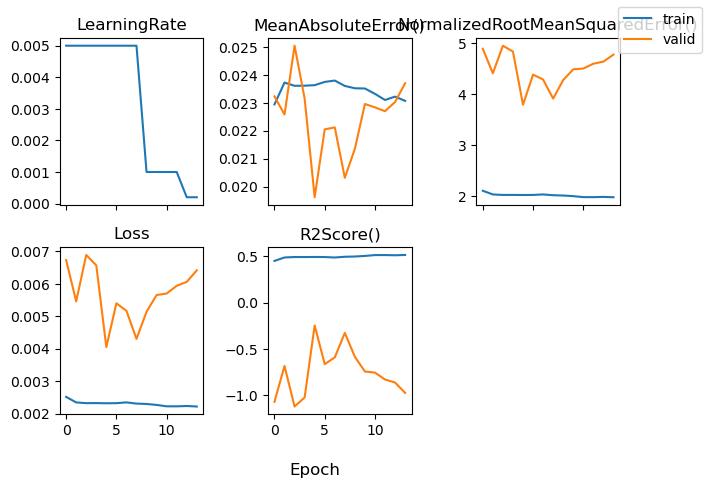

In [41]:
util.plot.plot_all_scalars_in_run(f"logs/{model_name}/history")